In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

sr = 96000

def sine_gen(amplitude, frequency, phase, duration, sample_rate):
    t_v = np.arange(0, duration, 1/sample_rate) 
    output = amplitude * np.sin(2 * np.pi * frequency * t_v + phase)
    return output

def square_gen(amplitude, frequency, phase, duration, sample_rate, num_harmonics):
    output = np.zeros(duration * sample_rate)
    curr_harmonic = 1
    for i in range(num_harmonics):
        output += sine_gen(1/curr_harmonic, curr_harmonic * frequency, 0, duration, sample_rate)
        curr_harmonic += 2
    return output * amplitude

def variable_triangle(amplitude, frequency, phase = 1, duration = 2, sample_rate = 96000):
    t_v = np.arange(0, duration, 1/sample_rate)
    output = np.zeros(duration * sample_rate)
    for i in range(1, 10, 2):
        output += sine_gen(1/i**2, i*frequency, 0, duration, sample_rate)
    return output

def crossMod(wv_1, wv_2):
    length = wv_1.size
    y = np.zeros(length)
    for i in range(length):
        interpFactor = i / length
        y[i] = (1 - interpFactor) * wv_1[i] + interpFactor * wv_2[i]
    return y

def progressively_decimate(signal):
    npSignal = np.array(signal)
    length = signal.size

    # splitting the signal into four slices, each of which will be decimated by a greater factor
    firstBound = np.floor(length / 4).astype(int)
    secondBound = firstBound * 2
    thirdBound = firstBound * 3

    # generating the new slices and decimating by taking every nth sample, as coded by the third argument
    firstSlice = npSignal[0:firstBound:1]
    secondSlice = npSignal[firstBound:secondBound:2]
    thirdSlice = npSignal[secondBound:thirdBound:3]
    fourthSlice = npSignal[thirdBound:length:4]

    # combining all the slices into a final return array of the progressively decimated signals
    y = np.concatenate((firstSlice, secondSlice, thirdSlice, fourthSlice))

    return y

def bitCrush(signal, new_bit_depth):
    # get new bit depth
    bdepth = 2 ** new_bit_depth
    # use new bit depth to rescale the signal
    scaled_signal = np.interp(signal, (-1, 1), (0, bdepth - 1))
    # Quantize by rounding to nearest integer
    quantized_signal = np.round(scaled_signal)
    # Rescale back to the range -1 to 1
    rescaled_signal = np.interp(quantized_signal, (0, bdepth - 1), (-1, 1))
    
    return rescaled_signal

def finalTransform(w1_freq, w2_freq, bitDepth, squareHarmonics, sr_bool, output_file = 'WT_out.wav'):
    # generate our sine and square waves
    sine1 = sine_gen(1, w1_freq, 0, 2, sr)
    square = square_gen(0.5, w2_freq, 0, 2, sr, squareHarmonics)
    # interpolate smoothly from the initial sine wave to the square wave
    returnTable = crossMod(sine1, square)
    # if the user specifies, perform progressive decimate the signal
    if sr_bool == 1:
        returnTable = progressively_decimate(returnTable)
    # bit crush the signal to the specified bit depth
    returnTable = bitCrush(returnTable, bitDepth)
    max_val = np.max(np.abs(returnTable))
    returnTable = returnTable / max_val
    sf.write(output_file, returnTable, sr)
    return returnTable

finalTransform(440,440, 24,25, 1, 'WT_1.wav')

array([ 5.96200569e-08,  2.88028668e-02,  5.75831376e-02, ...,
       -3.93601540e-01, -3.83546856e-01, -3.60179371e-01])

/var/folders/hn/n143pnwn29dfd740rsblrsx80000gn/T/ipykernel_48758/2034184049.py:25: RuntimeWarning: divide by zero encountered in divide
  x / first_segment_end,
/var/folders/hn/n143pnwn29dfd740rsblrsx80000gn/T/ipykernel_48758/2034184049.py:25: RuntimeWarning: invalid value encountered in divide
  x / first_segment_end,
/var/folders/hn/n143pnwn29dfd740rsblrsx80000gn/T/ipykernel_48758/2034184049.py:26: RuntimeWarning: divide by zero encountered in divide
  (period - x) / (period - second_segment_start))


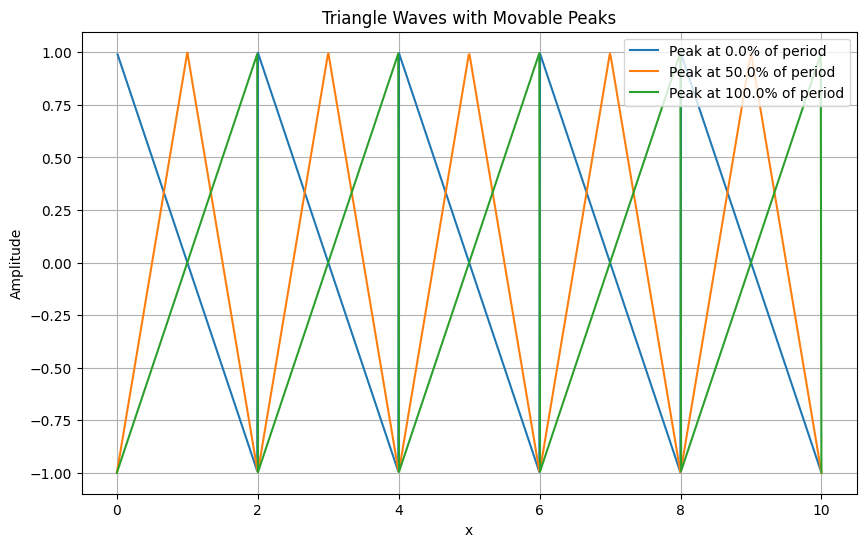

In [15]:
def triangle_wave(x, period, peak_pos):
    """
    Generate a triangle wave with a controllable peak position.
    
    Args:
    x (np.array): The input array of x values.
    period (float): The period of the triangle wave.
    peak_pos (float): The position of the peak within one period (0 to 1).

    Returns:
    np.array: The y values of the triangle wave.
    """
    # Ensure peak_pos is between 0 and 1
    peak_pos = np.clip(peak_pos, 0, 1)
    
    # Normalize x within one period
    x = x % period
    
    # Define the first segment from 0 to peak_pos
    first_segment_end = peak_pos * period
    second_segment_start = first_segment_end
    
    # Compute the wave
    y = np.where(x <= first_segment_end,
                 x / first_segment_end,
                 (period - x) / (period - second_segment_start))
    
    # Normalize the wave to have an amplitude between -1 and 1
    return 2 * y - 1

# Example usage
x = np.linspace(0, 10, 1000)  # Generate 1000 points from 0 to 10
peak_positions = [0.0, 0.5, 1.0]  # Different peak positions

plt.figure(figsize=(10, 6))
for peak_pos in peak_positions:
    y = triangle_wave(x, period=2, peak_pos=peak_pos)
    plt.plot(x, y, label=f'Peak at {peak_pos * 100}% of period')

plt.title('Triangle Waves with Movable Peaks')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

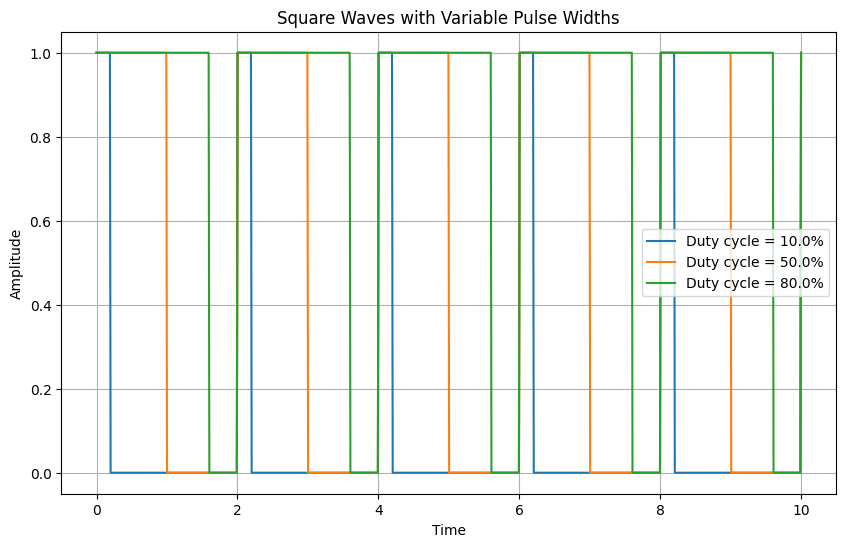

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def square_wave(t, period, duty_cycle, amplitude=1):
    """
    Generate a square wave with variable pulse width.
    
    Args:
    t (np.array): The input time array.
    period (float): The period of the square wave.
    duty_cycle (float): The duty cycle of the square wave (0 to 1).
    amplitude (float): The amplitude of the square wave.
    
    Returns:
    np.array: The amplitude values of the square wave.
    """
    return amplitude * (np.mod(t, period) < duty_cycle * period)

# Example usage
t = np.linspace(0, 10, 1000)  # time from 0 to 10 with 1000 points
duty_cycles = [0.1, 0.5, 0.8]  # different duty cycles

plt.figure(figsize=(10, 6))
for D in duty_cycles:
    y = square_wave(t, period=2, duty_cycle=D)
    plt.plot(t, y, label=f'Duty cycle = {D * 100}%')

plt.title('Square Waves with Variable Pulse Widths')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
sameFreqNoSR = finalTransform(440,440, 24,25, 0, 'sameFreqNoSR.wav')
Audio(sameFreqNoSR, rate = sr)

In [5]:
diffFreqNoSR = finalTransform(440,220, 24,25, 0, 'diffFreqNoSR.wav')
Audio(diffFreqNoSR, rate = sr)

In [6]:
sameFreqWithSR = finalTransform(440,440, 24,25, 1, 'sameFreqWithSR.wav')
Audio(sameFreqWithSR, rate = sr)

In [7]:
diffFreqWithSR = finalTransform(440,220, 24,25, 1, 'diffFreqWithSR.wav')
Audio(diffFreqWithSR, rate = sr)

In [8]:
sameFreqBitCrush = finalTransform(440,440, 4,25, 0, 'sameFreqBitCrush.wav')
Audio(sameFreqBitCrush, rate = sr)

In [9]:
bit10 = finalTransform(440,440, 10,25, 0, 'bit10.wav')
Audio(bit10, rate = sr)


In [10]:
bit6 = finalTransform(440,440, 6,25, 0, 'bit6.wav')
Audio(bit6, rate = sr)


In [11]:
bit4 = finalTransform(440,440, 4,25, 0, 'bit4.wav')
Audio(bit4, rate = sr)

In [12]:
bit2 = finalTransform(440,440, 2,25, 0, 'bit2.wav')
Audio(bit2, rate = sr)

In [13]:
diffFreqBitCrush = finalTransform(440,220, 4,25, 0, 'diffFreqBitCrush.wav')
Audio(diffFreqBitCrush, rate = sr)

In [14]:
whole_enchilada = finalTransform(440,220, 2,25, 1, 'whole_enchilada.wav')
Audio(whole_enchilada, rate = sr)